# Part 1: Wrangling and EDA

In [79]:
import pandas as pd

mdf = pd.read_csv('linked_mortality_file_1999_2000.csv')
gdf = pd.read_sas("DEMO.xpt", format="xport")
df = gdf.merge(mdf, on="SEQN", how="inner")

print(df.shape)
print(df.head())

(9965, 151)
   SEQN  SDDSRVYR  RIDSTATR  RIDEXMON  RIAGENDR  RIDAGEYR  RIDAGEMN  RIDAGEEX  \
0   1.0       1.0       2.0       2.0       2.0       2.0      29.0      31.0   
1   2.0       1.0       2.0       2.0       1.0      77.0     926.0     926.0   
2   3.0       1.0       2.0       1.0       2.0      10.0     125.0     126.0   
3   4.0       1.0       2.0       2.0       1.0       1.0      22.0      23.0   
4   5.0       1.0       2.0       2.0       1.0      49.0     597.0     597.0   

   RIDRETH1  RIDRETH2  ...      WTIREP50      WTIREP51      WTIREP52  \
0       4.0       2.0  ...  10327.992682   9809.165049  10323.315747   
1       3.0       1.0  ...  27268.025234  27406.383620  26984.812909   
2       3.0       1.0  ...  44480.987235  45389.112766  43781.905637   
3       4.0       2.0  ...  10851.024385  10564.981435  11012.529729   
4       3.0       1.0  ...  92817.926915  94282.855382  91993.251203   

   ELIGSTAT  MORTSTAT  UCOD_LEADING  DIABETES  HYPERTEN  PERMTH_INT 

## Key Variable Descriptions
- **ELIGSTAT**: Whether the participant was eligible for mortality follow-up (1=eligible, 2=ineligible).
- **MORTSTAT**: Vital status at the end of the follow-up (0=alive, 1=deceased). This is our main prediction target.
- **PERMTH_INT**: The months of follow-up from interview date until death or Dec 31, 2019. This will be used for survival regression.
- **RIDAGEEX**: Age in months at time of medical exam. More precise than RIDAGEYR (age in years) because it captures sub-year age differences. We will use this instead of RIDAGEYR throughout our analysis.

In [80]:
bmx = pd.read_sas("BMX.xpt", format="xport")
bpx = pd.read_sas("BPX.xpt", format="xport")

df = df.merge(bmx, on="SEQN", how="left")
df = df.merge(bpx, on="SEQN", how="left")

print(df.shape)

(9965, 217)


## Data Selection Rationale

Beyond demographics, I added two additional NHANES datasets:

- **Body Measures (BMX)**: Contains BMI, weight, and height. 
Obesity is a well-known risk factor for mortality.
- **Blood Pressure (BPX)**: Contains systolic and diastolic blood 
pressure readings. High blood pressure is a leading cause of 
cardiovascular death.

These variables, combined with age, gender, and race from the 
demographics file, give us a strong set of predictors for mortality.

In [81]:
print(df.isnull().sum())

SEQN           0
SDDSRVYR       0
RIDSTATR       0
RIDEXMON     683
RIAGENDR       0
            ... 
BPXSY4      8322
BPXDI4      8322
BPAEN4      7829
BPXSAR      2750
BPXDAR      2750
Length: 217, dtype: int64


## Missing Values

Key variables with missing data:
- **MORTSTAT**: 4,520 missing — these are ineligible participants, will be dropped
- **PERMTH_INT**: 4,992 missing — same reason
- **BMX columns**: ~1,000-2,000 missing — some participants skipped body measures exam
- **BPX columns**: up to 8,322 missing — many participants skipped later blood pressure readings

We will drop rows where MORTSTAT is missing since we cannot use 
those for prediction. Other missing values will be handled during 
modeling.

In [82]:
df_clean = df.dropna(subset=['MORTSTAT'])
print(df_clean.shape)

(5445, 217)


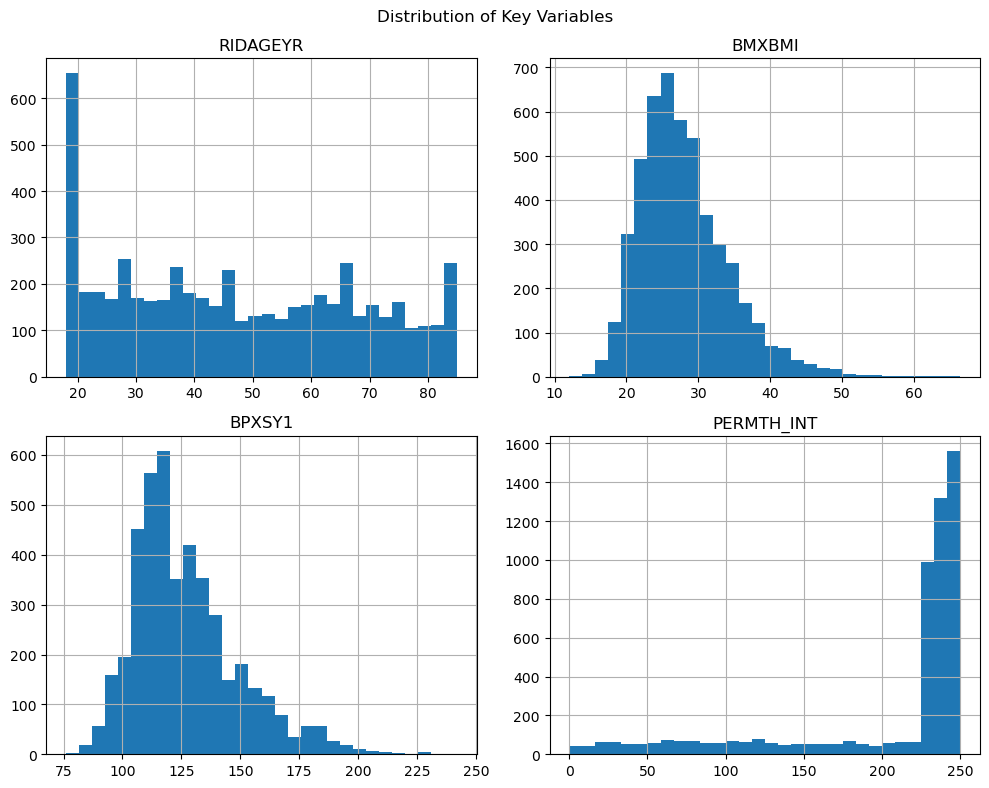

In [83]:
import matplotlib.pyplot as plt

key_vars = ['RIDAGEYR', 'BMXBMI', 'BPXSY1', 'PERMTH_INT']

df_clean[key_vars].hist(bins=30, figsize=(10,8))
plt.suptitle('Distribution of Key Variables')
plt.tight_layout()
plt.show()

## EDA - Skewness and Distributions

- **Age**: Roughly uniform across 18-85, slight spike at young adults.
- **BMI**: Right-skewed with some high outliers above 50, indicating 
  extreme obesity in a small number of participants.
- **Systolic Blood Pressure**: Roughly normal, slight right skew 
  toward high values.
- **PERMTH_INT**: Heavily right-skewed; most people survived the 
  full follow-up window, creating a large spike at the maximum value.

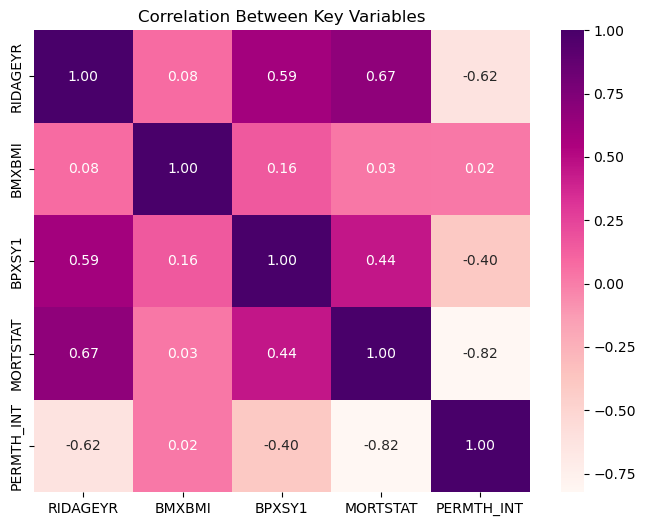

In [84]:
import seaborn as sns

corr_vars = ['RIDAGEYR', 'BMXBMI', 'BPXSY1', 'MORTSTAT', 'PERMTH_INT']
corr_matrix = df_clean[corr_vars].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='RdPu', fmt='.2f')
plt.title('Correlation Between Key Variables')
plt.show()

## EDA - Correlations

- Age is the strongest predictor of mortality (r=0.67) and negatively 
  correlated with survival time (r=-0.62).
- Systolic blood pressure is moderately correlated with mortality (r=0.44).
- BMI shows almost no correlation with mortality (r=0.03), suggesting 
  it may not be a useful predictor on its own.
- MORTSTAT and PERMTH_INT are strongly negatively correlated (r=-0.82), which makes sense --> people who died had fewer months of follow-up.

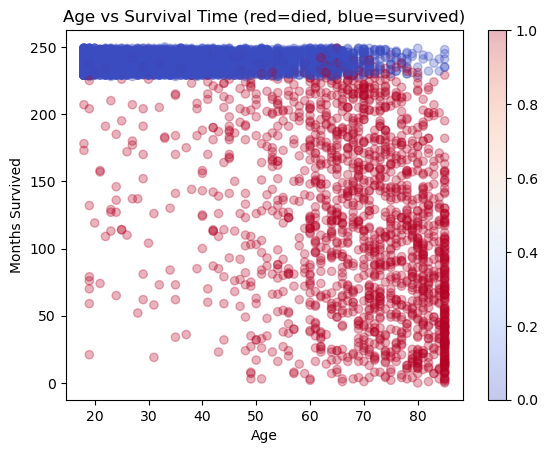

In [85]:
plt.scatter(df_clean['RIDAGEYR'], df_clean['PERMTH_INT'], 
            c=df_clean['MORTSTAT'], cmap='coolwarm', alpha=0.3)
plt.xlabel('Age')
plt.ylabel('Months Survived')
plt.title('Age vs Survival Time (red=died, blue=survived)')
plt.colorbar()
plt.show()

## EDA - Scatter Plot: Age vs Survival Time

Younger people (blue) cluster at the top --> they survived the full 
follow-up period of 250 months. Older people (red) have much lower 
survival times, dying earlier after the survey. This confirms that 
age is the strongest predictor of both mortality and survival time.

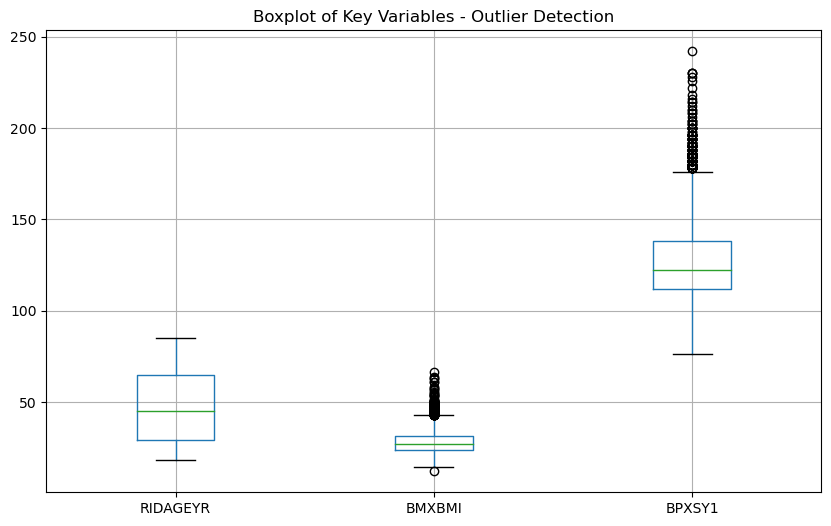

In [86]:
df_clean[['RIDAGEYR', 'BMXBMI', 'BPXSY1']].boxplot(figsize=(10,6))
plt.title('Boxplot of Key Variables - Outlier Detection')
plt.show()

## EDA - Outliers

BMI has several high outliers above 60, indicating a small number 
of extremely obese participants. Blood pressure has many outliers 
above 175, representing people with dangerously high hypertension. 
Age has no major outliers --> it is naturally capped at 85 in this dataset.

In [87]:
contingency = pd.crosstab(df_clean['RIAGENDR'], df_clean['MORTSTAT'], rownames=['Gender'], colnames=['Mortality (0=Alive, 1=Dead)'])

print(contingency)

Mortality (0=Alive, 1=Dead)   0.0  1.0
Gender                                
1.0                          1665  883
2.0                          2105  792


## EDA - Contingency Table: Race/Ethnicity vs Mortality

In [88]:
race_labels = {1: 'Mexican American', 2: 'Other Hispanic', 3: 'Non-Hispanic White', 4: 'Non-Hispanic Black', 5: 'Other'}

df_clean = df_clean.copy()
df_clean['RACE_LABEL'] = df_clean['RIDRETH1'].map(race_labels)

race_contingency = pd.crosstab(df_clean['RACE_LABEL'], df_clean['MORTSTAT'], rownames=['Race/Ethnicity'], colnames=['Mortality (0=Alive, 1=Dead)'])
print(race_contingency)

race_contingency['Mortality Rate %'] = (race_contingency[1.0] / (race_contingency[0.0] + race_contingency[1.0]) * 100).round(1)
print("\n", race_contingency)

Mortality (0=Alive, 1=Dead)   0.0  1.0
Race/Ethnicity                        
Mexican American             1185  366
Non-Hispanic Black            715  320
Non-Hispanic White           1458  871
Other                         148   45
Other Hispanic                264   73

 Mortality (0=Alive, 1=Dead)   0.0  1.0  Mortality Rate %
Race/Ethnicity                                          
Mexican American             1185  366              23.6
Non-Hispanic Black            715  320              30.9
Non-Hispanic White           1458  871              37.4
Other                         148   45              23.3
Other Hispanic                264   73              21.7


## The contingency table reveals meaningful differences in mortality rates across racial/ethnic groups:

- Non-Hispanic White participants had the highest mortality rate (37.4%), likely 
reflecting the older age distribution in this group.
- Non-Hispanic Black participants had the second highest rate (30.9%), which may 
reflect known health disparities in access to care and chronic disease burden.
- Mexican American (23.6%), Other Hispanic (21.7%), and Other (23.3%) groups had 
the lowest mortality rates, possibly due to younger age distributions.

This suggests race/ethnicity is a meaningful predictor of mortality, though we 
must be careful, racial differences in mortality often reflect systemic health 
disparities rather than biological differences. Using race as a predictor risks 
reinforcing these disparities rather than addressing their root causes.

# Part 2: k-NN classification/regression, write-up

## 1. Data Description

The data comes from two sources merged together:

- **NHANES 1999-2000**: Collected by the CDC to assess the health 
  and nutritional status of adults in the US. Each observation is 
  one survey participant. It includes demographics, body measures, 
  and blood pressure readings.
- **CDC Linked Mortality File**: Tracks whether NHANES participants 
  later died, and how long they lived after the survey.

**Missing data**: 4,520 participants were ineligible for mortality 
follow-up and were dropped. Some participants are missing BMI or 
blood pressure readings.

**Limitations**: The data is from 1999-2000, so it may not reflect 
current health trends. Mortality is tracked only until 2019, so 
some participants may have died after that cutoff.

## 2. Variable Selection and Analysis
I selected the following variables to predict mortality and life expectancy:

- **RIDAGEEX**: Age in months at time of medical examination. More precise than 
RIDAGEYR (age in years) because it captures sub-year age differences, which matter 
more at older ages.
- **RIAGENDR**: Gender. Men have higher mortality rates than women.
- **RIDRETH1**: Race/ethnicity. Known to correlate with health outcomes.
- **BMXBMI**: BMI. Indicator of obesity related health risks.
- **BPXSY1**: Systolic blood pressure. High BP is a major mortality risk.

In [89]:
features = ['RIDAGEEX', 'RIAGENDR', 'RIDRETH1', 'BMXBMI', 'BPXSY1']

df_model = df_clean[features + ['MORTSTAT', 'PERMTH_INT']].dropna()
print(df_model.shape)
print(df_model.describe())

(4190, 7)
          RIDAGEEX     RIAGENDR     RIDRETH1       BMXBMI       BPXSY1  \
count  4190.000000  4190.000000  4190.000000  4190.000000  4190.000000   
mean    551.843198     1.526730     2.607876    28.032594   126.174224   
std     234.402597     0.499345     1.188866     6.146150    21.909844   
min     216.000000     1.000000     1.000000    12.040000    76.000000   
25%     342.000000     1.000000     1.000000    23.720000   110.000000   
50%     528.500000     2.000000     3.000000    27.030000   122.000000   
75%     756.000000     2.000000     3.000000    31.330000   138.000000   
max    1019.000000     2.000000     5.000000    63.910000   242.000000   

          MORTSTAT   PERMTH_INT  
count  4190.000000  4190.000000  
mean      0.268974   210.099523  
std       0.443479    59.244261  
min       0.000000     1.000000  
25%       0.000000   226.000000  
50%       0.000000   236.000000  
75%       1.000000   243.000000  
max       1.000000   250.000000  


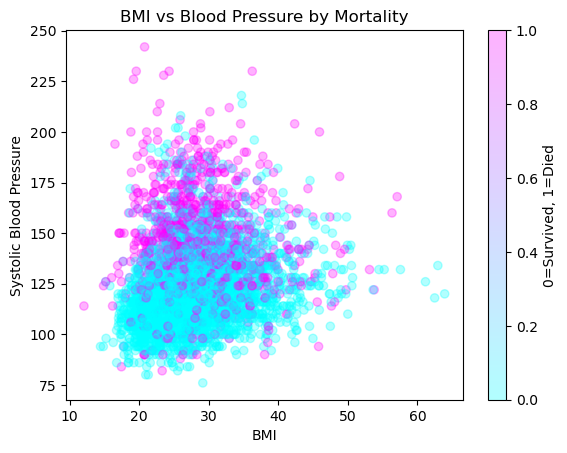

In [90]:
plt.scatter(df_model['BMXBMI'], df_model['BPXSY1'],
            c=df_model['MORTSTAT'], cmap='cool', alpha=0.3)
plt.xlabel('BMI')
plt.ylabel('Systolic Blood Pressure')
plt.title('BMI vs Blood Pressure by Mortality')
plt.colorbar(label='0=Survived, 1=Died')
plt.show()

The scatter plot shows BMI vs blood pressure colored by who died (red) and who survived (blue). Red points are more concentrated at higher blood pressure values, confirming that high blood pressure is linked to mortality. BMI alone does not separate the two groups well --> people across all BMI levels died, but those with high blood pressure were more likely to die.

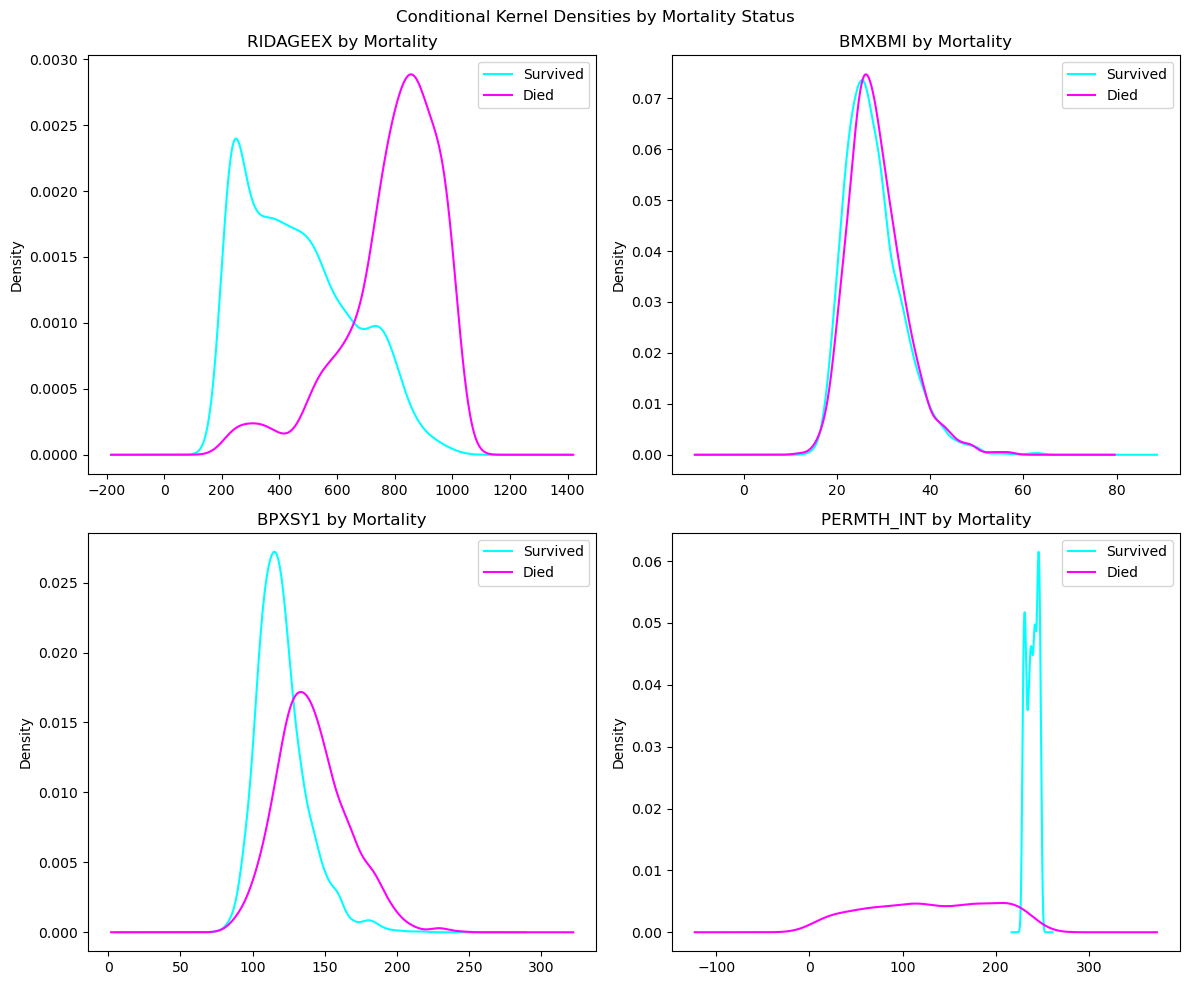

In [91]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for col, ax in zip(['RIDAGEEX', 'BMXBMI', 'BPXSY1', 'PERMTH_INT'], axes.flatten()):
    df_model[df_model['MORTSTAT']==0][col].plot.kde(ax=ax, label='Survived', color='aqua')
    df_model[df_model['MORTSTAT']==1][col].plot.kde(ax=ax, label='Died', color='magenta')
    ax.set_title(f'{col} by Mortality')
    ax.legend()

plt.suptitle('Conditional Kernel Densities by Mortality Status')
plt.tight_layout()
plt.show()

## Variable Analysis Discussion

The conditional kernel densities reveal clear patterns:

- **Age** shows the strongest separation between survivors and 
  those who died, confirming it is the most important predictor.
- **BMI** shows almost no difference between groups, suggesting 
  limited predictive power on its own.
- **Blood pressure** shows a rightward shift for those who died, 
  indicating higher BP is associated with mortality.
- **PERMTH_INT** shows survivors clustered at the maximum follow-up 
  time (250 months), while those who died are spread across earlier 
  months, as expected.

## 3. k-NN Mortality Classifier

In [92]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

X = df_model[features]
y = df_model['MORTSTAT']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

k_values = [1, 3, 5, 10, 20, 50]
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))
    print(f"k={k}, Accuracy: {accuracy_score(y_test, y_pred):.4f}")

k=1, Accuracy: 0.7828
k=3, Accuracy: 0.8222
k=5, Accuracy: 0.8353
k=10, Accuracy: 0.8294
k=20, Accuracy: 0.8353
k=50, Accuracy: 0.8377


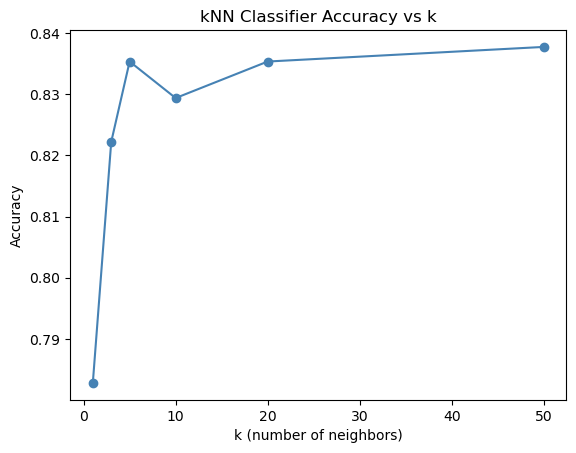

Confusion Matrix:
[[563  46]
 [ 90 139]]


In [93]:
plt.plot(k_values, accuracies, marker='o', color='steelblue')
plt.xlabel('k (number of neighbors)')
plt.ylabel('Accuracy')
plt.title('kNN Classifier Accuracy vs k')
plt.show()

knn_best = KNeighborsClassifier(n_neighbors=50)
knn_best.fit(X_train, y_train)
y_pred = knn_best.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

## Classifier Results

The best k is 50, with 83.7% accuracy. Accuracy increases as k grows 
then flattens out, suggesting k=50 is a good choice.

The confusion matrix shows the model is better at identifying 
survivors than those who died. 90 deaths were missed (predicted as 
surviving) --> this is important in a health context since missing a 
death prediction could have real consequences.

In [94]:
from sklearn.model_selection import cross_val_score

X_cv = df_model[features].values
y_cv = df_model['MORTSTAT'].values

scaler_cv = StandardScaler()
X_cv_scaled = scaler_cv.fit_transform(X_cv)

knn_cv = KNeighborsClassifier(n_neighbors=50)
cv_scores = cross_val_score(knn_cv, X_cv_scaled, y_cv, cv=5, scoring='accuracy')
print(f"5-Fold CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"Individual fold scores: {[round(s, 4) for s in cv_scores]}")

5-Fold CV Accuracy: 0.8532 ± 0.0112
Individual fold scores: [0.8496, 0.8652, 0.8484, 0.8663, 0.8365]


## Cross-Validation Results

5-fold cross-validation confirms that k=50 generalizes well, achieving a mean 
accuracy of 85.3% (± 1.1%) across all 5 folds. The low standard deviation 
indicates the model is stable and consistent, confirming our results are not 
due to a lucky train/test split.

## 4. k-NN Life Expectancy Regressor

In [95]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

X = df_model[features]
y = df_model['PERMTH_INT']

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

k_values = [1, 3, 5, 10, 20, 50]
rmses = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmses.append(rmse)
    print(f"k={k}, RMSE: {rmse:.2f}")

k=1, RMSE: 67.42
k=3, RMSE: 54.20
k=5, RMSE: 52.10
k=10, RMSE: 49.68
k=20, RMSE: 49.06
k=50, RMSE: 49.06


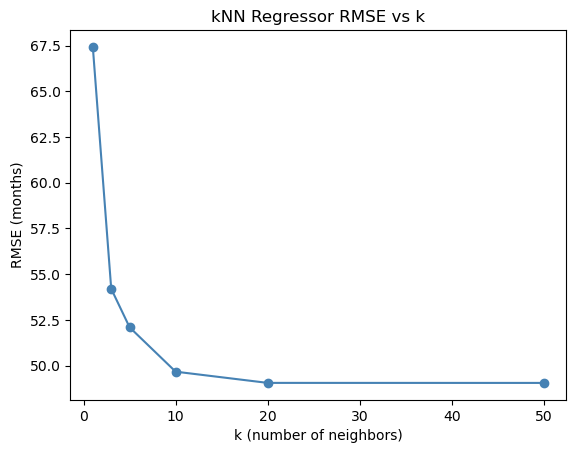

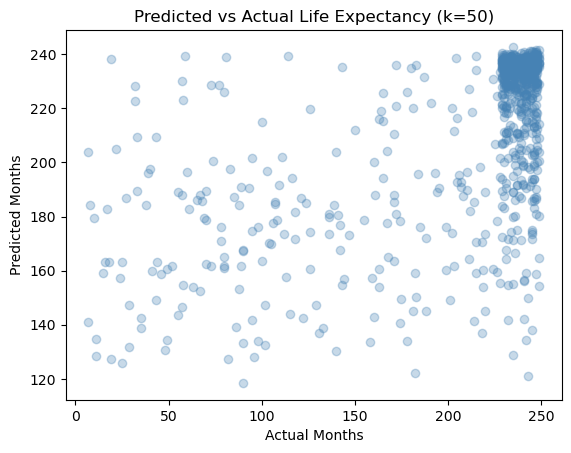

In [96]:
plt.plot(k_values, rmses, marker='o', color='steelblue')
plt.xlabel('k (number of neighbors)')
plt.ylabel('RMSE (months)')
plt.title('kNN Regressor RMSE vs k')
plt.show()

knn_reg = KNeighborsRegressor(n_neighbors=50)
knn_reg.fit(X_train, y_train)
y_pred = knn_reg.predict(X_test)

plt.scatter(y_test, y_pred, alpha=0.3, color='steelblue')
plt.xlabel('Actual Months')
plt.ylabel('Predicted Months')
plt.title('Predicted vs Actual Life Expectancy (k=50)')
plt.show()

## Regressor Results

RMSE decreases as k increases, with k=50 performing best at 49 months error. 
This means our predictions are off by about 4 years on average.

The scatter plot shows the model struggles to predict exact survival time, 
predictions cluster toward higher values because most people survived the full 
follow-up period. This is a known limitation of kNN regression when the target 
variable is heavily skewed, as PERMTH_INT is.

k=50 was selected because it minimizes RMSE and the curve flattens out after 
k=20, suggesting larger k values do not improve much further.

# 5. Health Interventions, Limitations, and Risks

### How This Model Could Be Used

This kNN model predicts whether a patient is likely to die within a 20-year 
follow-up window and how many months they are likely to survive, based on age 
(in months), gender, race/ethnicity, BMI, and systolic blood pressure. All 
features were standardized before modeling to ensure equal contribution to 
distance calculations.

In a health intervention context, this model could be used to:

- **Flag high-risk patients for preventive care**: The model identifies older 
patients with high blood pressure as the highest-risk group. These patients 
could be prioritized for regular checkups, medication reviews, and cardiovascular 
screening programs before a crisis may actually occur.

- **Distribute public health resources more efficiently**: In settings with limited 
resources, the classifier (83.7% accuracy, 85.3% cross-validated) can help 
organize which patients need the most immediate attention, allowing providers to 
focus intensive care where it is most needed.

- **Guide targeted lifestyle interventions**: Patients with high BMI or elevated 
systolic blood pressure (above 150 mmHg, where mortality risk increases based 
on our EDA) could be targeted for diet and exercise programs.

- **Support survival planning**: The regressor estimates how many months a 
patient is likely to survive (RMSE = 49 months). While too imprecise for 
individual clinical decisions, it could inform population-level planning for 
hospice care and long-term medical care facilities.

### Limitations

- **Age dominates the model**: Age (RIDAGEEX) is by far the strongest predictor 
(r=0.67 with MORTSTAT). This means the model may overlook patients who are 
younger but at high risk due to factors not captured here, such as smoking 
history, diabetes, or family history of disease.

- **Missing important predictors**: The CDC Linked Mortality File includes 
DIABETES and HYPERTEN variables that we did not include in our model. Including 
these could meaningfully improve performance, especially for younger high-risk 
patients.

- **Data is from 1999-2000**: Medical treatments, life expectancy, and health 
trends have changed significantly in the past 25 years. The model may not 
reflect current mortality patterns.

- **RMSE of 49 months**: The regressor is off by about 4 years on average, 
which is too imprecise for individual clinical use. It is better suited for 
population-level analysis than individual predictions.

- **Missed deaths**: The classifier missed 90 deaths in the test set 
(confusion matrix: [[563, 46], [90, 139]]). In a real health setting, 
failing to flag someone as high-risk could delay life-saving treatments or diagnoses.

- **Mortality censored at 2019**: Some participants who were still alive at 
the end of follow-up may have died after December 31, 2019. This means our 
model slightly underestimates true mortality risk.

### Ethical Risks

- **Racial bias**: Race/ethnicity is included as a predictor because it 
correlates with mortality outcomes in our data (Non-Hispanic White: 37.4% 
mortality, Non-Hispanic Black: 30.9%, Mexican American: 23.6%). However, 
these differences largely reflect systemic disparities in access to healthcare, 
socioeconomic conditions, and chronic disease burden, not biological 
differences. Using race as a predictor risks encoding and reinforcing these 
disparities rather than addressing their root causes.

- **Fairness**: Model predictions should never be used to deny care or 
not prioritize certain patients. A patient predicted as low-risk still deserves full 
clinical evaluation. The model is a screening tool, not a decision-maker.

- **Privacy**: This model was built on individually linked health and mortality 
data. Any real-world deployment would require strict data governance, patient 
consent, and compliance with HIPAA regulations.

- **Over-reliance on a single model**: kNN is a relatively simple algorithm. 
Before utilizing it in real-world clinical environments, this model should be tested against stronger 
methods such as logistic regression or survival models like the "Cox proportional hazards".

### This model is best used as a population-level screening tool to support, NOT REPLACE, clinical judgment from medical professionals.